In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.cuda.amp import GradScaler, autocast

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import math
from pathlib import Path
import json
from datetime import datetime
from timm import create_model

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

class DCTLayer(nn.Module):
    def __init__(self, patch_size=8):
        super().__init__()
        self.patch_size = patch_size
        
        self.register_buffer('dct_basis', self._create_dct_basis())
        
    def _create_dct_basis(self):
        p = self.patch_size
        dct_basis = torch.zeros(p, p)
        
        for u in range(p):
            for v in range(p):
                if u == 0:
                    Cu = 1.0 / math.sqrt(p)
                else:
                    Cu = math.sqrt(2.0 / p)
                    
                for x in range(p):
                    dct_basis[u, x] = Cu * math.cos((2 * x + 1) * u * math.pi / (2 * p))
                    
        return dct_basis
    
    def forward(self, x):
        B, C, H, W = x.shape
        
        if H % self.patch_size != 0 or W % self.patch_size != 0:
            x = F.pad(x, (0, self.patch_size - W % self.patch_size, 
                          0, self.patch_size - H % self.patch_size))
            _, _, H, W = x.shape
        
        x_patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x_patches = x_patches.contiguous().view(B, C, -1, self.patch_size, self.patch_size)
        
        dct_1 = torch.matmul(self.dct_basis.unsqueeze(0), x_patches)
        dct_2 = torch.matmul(dct_1.transpose(-2, -1), self.dct_basis.T.unsqueeze(0))
        
        num_patches_h = H // self.patch_size
        num_patches_w = W // self.patch_size
        dct_2 = dct_2.view(B, C, num_patches_h, num_patches_w, self.patch_size, self.patch_size)
        dct_2 = dct_2.permute(0, 1, 2, 4, 3, 5).contiguous()
        dct_2 = dct_2.view(B, C, H, W)
        
        return dct_2

class ArtifactAttentionModule(nn.Module):
    def __init__(self, in_channels, reduction_ratio=4):
        super().__init__()
        
        self.dct_layer = DCTLayer(patch_size=8)
        self.freq_conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels // reduction_ratio),
            nn.GELU(),
            nn.Conv2d(in_channels // reduction_ratio, in_channels // reduction_ratio, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels // reduction_ratio),
            nn.GELU()
        )
        
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1),
            nn.BatchNorm2d(in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
        
        self.num_heads = 4
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=in_channels,
            num_heads=self.num_heads,
            dropout=0.1,
            batch_first=True
        )
        
        self.fusion_gate = nn.Parameter(torch.ones(1, in_channels, 1, 1))
        
        self.fusion = nn.Sequential(
            nn.Conv2d(in_channels + in_channels // reduction_ratio, in_channels, kernel_size=1),
            nn.BatchNorm2d(in_channels),
            nn.GELU()
        )
        
    def forward(self, x):
        B, C, H, W = x.shape
        
        x_dct = self.dct_layer(x)
        freq_features = self.freq_conv(x_dct)
        
        spatial_att = self.spatial_attention(x)
        spatial_features = x * spatial_att
        
        spatial_flat = spatial_features.flatten(2).transpose(1, 2)  
        
        freq_up = F.interpolate(freq_features, size=(H, W), mode='bilinear', align_corners=False)
        freq_flat = freq_up.flatten(2).transpose(1, 2)  
        
        freq_flat_padded = F.pad(freq_flat, (0, C - freq_flat.size(-1)))
        
        attended_features, _ = self.cross_attention(
            query=spatial_flat,
            key=freq_flat_padded,
            value=freq_flat_padded
        )
        attended_features = attended_features.transpose(1, 2).reshape(B, C, H, W)
        
        gate = torch.sigmoid(self.fusion_gate)
        
        combined = torch.cat([attended_features, freq_up], dim=1)
        fused = self.fusion(combined)
        
        output = x + fused
        
        return output

class AAMSwinTransformer(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super().__init__()
        
        self.backbone = create_model('swin_base_patch4_window7_224', pretrained=pretrained)
        
        embed_dims = [256, 512, 1024, 1024]
        
        self.aam_modules = nn.ModuleList([
            ArtifactAttentionModule(dim) for dim in embed_dims
        ])
        
        num_features = self.backbone.num_features
        self.backbone.head = nn.Identity()
        
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
        self.uncertainty_head = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward_features(self, x):
        x = self.backbone.patch_embed(x)
        if self.backbone.absolute_pos_embed is not None:
            x = x + self.backbone.absolute_pos_embed
        x = self.backbone.pos_drop(x)
        
        H, W = self.backbone.patch_embed.grid_size
        B, L, C = x.shape
        
        resolutions = [(H, W)]
        
        for i, layer in enumerate(self.backbone.layers):

            input_res = resolutions[-1]

            x = layer(x)
            
            if layer.downsample is not None:
                H, W = input_res[0] // 2, input_res[1] // 2
                resolutions.append((H, W))
            else:
                resolutions.append(input_res)
            
            curr_res = resolutions[-1]
            curr_H, curr_W = curr_res
            
            B, L, C = x.shape
            x_2d = x.transpose(1, 2).view(B, C, curr_H, curr_W)
            
            x_2d = self.aam_modules[i](x_2d)
            
            x = x_2d.flatten(2).transpose(1, 2)
        
        x = self.backbone.norm(x)
        
        x = x.mean(dim=1)
        
        return x
        
    def forward(self, x):

        features = self.forward_features(x)

        logits = self.classifier(features)
        
        uncertainty = self.uncertainty_head(features)
        
        return {
            'logits': logits,
            'uncertainty': uncertainty,
            'features': features
        }
    





class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        p = torch.exp(-ce_loss)
        loss = self.alpha * (1 - p) ** self.gamma * ce_loss
        return loss.mean()
    


class DegradationAugmentation:
    def __init__(self, p_degrade=0.5):
        self.p_degrade = p_degrade
        
    def jpeg_compression(self, img, quality=None):
        if quality is None:
            quality = np.random.randint(30, 95)
        
        noise = torch.randn_like(img) * (0.1 * (100 - quality) / 100)
        return torch.clamp(img + noise, 0, 1)
    
    def gaussian_blur(self, img, sigma=None):
        if sigma is None:
            sigma = np.random.uniform(0.5, 5.0)
            
        kernel_size = int(2 * np.ceil(3 * sigma) + 1)
        
        x = torch.arange(kernel_size, dtype=torch.float32, device=img.device) - kernel_size // 2
        gauss = torch.exp(-x.pow(2) / (2 * sigma ** 2))
        kernel = gauss / gauss.sum()
        kernel = kernel.view(1, 1, kernel_size) * kernel.view(1, kernel_size, 1)
        
        C = img.shape[0]
        kernel = kernel.repeat(C, 1, 1, 1)
        img = F.pad(img.unsqueeze(0), (kernel_size//2, kernel_size//2, kernel_size//2, kernel_size//2), mode='reflect')
        img = F.conv2d(img, kernel, groups=C)
        
        return img.squeeze(0)
    
    def resolution_reduction(self, img, scale=None):
        if scale is None:
            scale = np.random.choice([0.25, 0.5, 0.75])
            
        _, H, W = img.shape
        low_res = F.interpolate(img.unsqueeze(0), scale_factor=scale, mode='bilinear', align_corners=False)
        restored = F.interpolate(low_res, size=(H, W), mode='bilinear', align_corners=False)
        
        return restored.squeeze(0)
    
    def __call__(self, img):
        if np.random.random() < self.p_degrade:
            degradation_type = np.random.choice(['jpeg', 'blur', 'resolution', 'combined'])
            
            if degradation_type == 'jpeg':
                return self.jpeg_compression(img)
            elif degradation_type == 'blur':
                return self.gaussian_blur(img)
            elif degradation_type == 'resolution':
                return self.resolution_reduction(img)
            else:  # combined
                img = self.jpeg_compression(img)
                if np.random.random() < 0.5:
                    img = self.gaussian_blur(img)
                if np.random.random() < 0.5:
                    img = self.resolution_reduction(img)
                return img
        
        return img


class AIGeneratedDataset(Dataset):
    def __init__(self, root_dir, transform=None, degradation=None, is_training=False):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.degradation = degradation
        self.is_training = is_training
        
        self.images = []
        self.labels = []
        
        real_dir = self.root_dir / 'REAL'
        if real_dir.exists():
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
                for img_path in real_dir.glob(ext):
                    self.images.append(str(img_path))
                    self.labels.append(0)
            
        # Fake images (label=1)
        fake_dir = self.root_dir / 'FAKE'
        if fake_dir.exists():
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
                for img_path in fake_dir.glob(ext):
                    self.images.append(str(img_path))
                    self.labels.append(1)
            
        print(f"Dataset {root_dir}: {len(self.images)} images "
              f"({sum(l==0 for l in self.labels)} real, {sum(l==1 for l in self.labels)} fake)")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
            
        # Apply degradation (only during training)
        if self.degradation is not None and self.is_training:
            image = self.degradation(image)
            
        return image, label

class Config:
    data_dir = './data'  
    output_dir = './outputs'
    
    model_name = 'aam_swin'
    pretrained = True
    
    batch_size = 8  
    num_workers = 0
    
    phase1_epochs = 20 
    phase2_epochs = 30
    phase3_epochs = 10
    
    lr = 1e-4
    weight_decay = 0.05
    
    gpu = 0
    seed = 42
    
    save_interval = 5
    log_interval = 10

config = Config()

Path(config.output_dir).mkdir(parents=True, exist_ok=True)

class ThreePhaseTrainer:
    def __init__(self, model, config):
        self.model = model
        self.config = config
        self.device = device
        self.model.to(self.device)
        
        self.focal_loss = FocalLoss(alpha=0.25, gamma=2.0)
        self.ce_loss = nn.CrossEntropyLoss()
        
        self.best_val_acc = 0
        self.phase = 1
        
        self.save_dir = Path(config.output_dir) / config.model_name
        self.save_dir.mkdir(parents=True, exist_ok=True)
        
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        
    def setup_data_loaders(self):
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            normalize,
        ])

        val_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize
        ])

        degradation = DegradationAugmentation(p_degrade=0.5) if self.phase >= 2 else None

        train_dataset = AIGeneratedDataset(
            os.path.join(self.config.data_dir, 'train'),
            transform=train_transform,
            degradation=degradation,
            is_training=True
        )
        
        val_dataset = AIGeneratedDataset(
            os.path.join(self.config.data_dir, 'test'),
            transform=val_transform,
            is_training=False
        )
        
        self.train_loader = DataLoader(
            train_dataset,
            batch_size=self.config.batch_size,
            shuffle=True,
            num_workers=self.config.num_workers,
            pin_memory=True,
            drop_last=True
        )
        
        self.val_loader = DataLoader(
            val_dataset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=self.config.num_workers,
            pin_memory=True
        )
        
        return self.train_loader, self.val_loader
    
    def setup_optimizer_phase1(self):

        for param in self.model.backbone.parameters():
            param.requires_grad = False
        
        for param in self.model.aam_modules.parameters():
            param.requires_grad = True
            
        self.optimizer = optim.AdamW(
            filter(lambda p: p.requires_grad, self.model.parameters()),
            lr=self.config.lr,
            weight_decay=self.config.weight_decay
        )
        
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=self.config.phase1_epochs
        )
        
    def setup_optimizer_phase2(self):

        for param in self.model.parameters():
            param.requires_grad = True
            
        self.optimizer = optim.AdamW([
            {'params': self.model.backbone.parameters(), 'lr': self.config.lr * 0.1},
            {'params': self.model.aam_modules.parameters(), 'lr': self.config.lr},
            {'params': self.model.classifier.parameters(), 'lr': self.config.lr},
            {'params': self.model.uncertainty_head.parameters(), 'lr': self.config.lr}
        ], weight_decay=self.config.weight_decay)
        
        self.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer, T_0=10, T_mult=2, eta_min=1e-6
        )
        
    def setup_optimizer_phase3(self):
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=self.config.lr * 0.01,
            weight_decay=self.config.weight_decay
        )
        
        self.scheduler = optim.lr_scheduler.StepLR(
            self.optimizer, step_size=5, gamma=0.5
        )
    
    def train_epoch(self, epoch):
        self.model.train()
        
        total_loss = 0
        correct = 0
        total = 0
        
        pbar = tqdm(self.train_loader, desc=f'Train Epoch {epoch} (Phase {self.phase})')
        
        for batch_idx, (images, labels) in enumerate(pbar):
            images, labels = images.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()
            
            # Forward pass
            outputs = self.model(images)
            
            # Compute loss based on phase
            if self.phase == 1:
                loss = self.ce_loss(outputs['logits'], labels)
            elif self.phase == 2:
                loss = self.focal_loss(outputs['logits'], labels)
            else:  # Phase 3
                loss = self.ce_loss(outputs['logits'], labels)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Update metrics
            total_loss += loss.item()
            _, predicted = outputs['logits'].max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100. * correct / total:.2f}%'
            })
        
        return total_loss / len(self.train_loader), 100. * correct / total
    
    def validate(self, epoch):
        self.model.eval()
        
        total_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc=f'Val Epoch {epoch}')
            
            for images, labels in pbar:
                images, labels = images.to(self.device), labels.to(self.device)
                
                outputs = self.model(images)
                loss = self.ce_loss(outputs['logits'], labels)
                
                total_loss += loss.item()
                _, predicted = outputs['logits'].max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100. * correct / total:.2f}%'
                })
        
        val_loss = total_loss / len(self.val_loader)
        val_acc = 100. * correct / total
        
        return val_loss, val_acc
    
    def save_checkpoint(self, epoch, val_acc, is_best=False):
        checkpoint = {
            'epoch': epoch,
            'phase': self.phase,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'val_acc': val_acc,
            'config': vars(self.config),
            'history': self.history
        }

        checkpoint_path = self.save_dir / f'checkpoint_phase{self.phase}_epoch{epoch}.pth'
        torch.save(checkpoint, checkpoint_path)
        
        if is_best:
            best_path = self.save_dir / f'best_model_phase{self.phase}.pth'
            torch.save(checkpoint, best_path)
            print(f"New best model saved with accuracy: {val_acc:.2f}%")
    
    def plot_training_history(self):
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['val_loss'], label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        
        plt.subplot(1, 2, 2)
        plt.plot(self.history['train_acc'], label='Train Acc')
        plt.plot(self.history['val_acc'], label='Val Acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.title('Training and Validation Accuracy')
        
        plt.tight_layout()
        plt.savefig(self.save_dir / 'training_history.png')
        plt.show()
    
    def train(self):
        total_epochs = 0
        
        print("\n=== Phase 1: Artifact-Specific Pretraining ===")
        self.phase = 1
        self.setup_data_loaders()
        self.setup_optimizer_phase1()
        
        phase1_best_acc = 0
        for epoch in range(1, self.config.phase1_epochs + 1):
            train_loss, train_acc = self.train_epoch(epoch)
            val_loss, val_acc = self.validate(epoch)
            self.scheduler.step()

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            
            print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            
            if val_acc > phase1_best_acc:  
                phase1_best_acc = val_acc
                self.save_checkpoint(epoch, val_acc, is_best=True)

        print("\n=== Phase 2: Degradation-Aware Joint Training ===")
        self.phase = 2
        self.setup_data_loaders() 
        self.setup_optimizer_phase2()
        
        phase2_best_acc = 0
        for epoch in range(1, self.config.phase2_epochs + 1):
            train_loss, train_acc = self.train_epoch(epoch)
            val_loss, val_acc = self.validate(epoch)
            self.scheduler.step()
            
           
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            
            print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            
            if val_acc > phase2_best_acc:
                phase2_best_acc = val_acc
                self.save_checkpoint(epoch, val_acc, is_best=True)
        
      
        print("\n=== Phase 3: Adversarial Robustness Tuning ===")
        self.phase = 3
        self.setup_optimizer_phase3()
        
        phase3_best_acc = 0
        for epoch in range(1, self.config.phase3_epochs + 1):
            train_loss, train_acc = self.train_epoch(epoch)
            val_loss, val_acc = self.validate(epoch)
            self.scheduler.step()
            
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            
            print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

            if val_acc > phase3_best_acc:
                phase3_best_acc = val_acc
                self.save_checkpoint(epoch, val_acc, is_best=True)
        
        print("\n=== Training Complete ===")
        print(f"Best accuracy - Phase 1: {phase1_best_acc:.2f}%, Phase 2: {phase2_best_acc:.2f}%, Phase 3: {phase3_best_acc:.2f}%")
        
        
        self.plot_training_history()
        
        final_checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'config': vars(self.config),
            'best_acc': {
                'phase1': phase1_best_acc,
                'phase2': phase2_best_acc,
                'phase3': phase3_best_acc
            },
            'history': self.history
        }
        torch.save(final_checkpoint, self.save_dir / 'final_model.pth')
        
        return self.history

print("Creating AAM-Swin Transformer model...")
model = AAMSwinTransformer(num_classes=2, pretrained=config.pretrained)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


print("Training setup complete! Uncomment the line above to start training.")


def load_model_for_inference(checkpoint_path, device):
    model = AAMSwinTransformer(num_classes=2, pretrained=False)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

def predict_single_image(model, image_path, device):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs['logits'], dim=1)
        uncertainty = outputs['uncertainty'].item()
        
    fake_prob = probs[0, 1].item()
    is_fake = fake_prob > 0.5
    
    return {
        'is_ai_generated': is_fake,
        'ai_probability': fake_prob,
        'real_probability': probs[0, 0].item(),
        'uncertainty': uncertainty,
        'confidence': 1 - uncertainty
    }

def visualize_predictions(model, data_loader, num_images=8, device='cuda'):
    
    model.eval()
    
    images, labels, predictions = [], [], []
    
    with torch.no_grad():
        for batch_images, batch_labels in data_loader:
            batch_images = batch_images.to(device)
            outputs = model(batch_images)
            probs = F.softmax(outputs['logits'], dim=1)
            preds = probs[:, 1] > 0.5  # Probability of being fake
            
            images.extend(batch_images.cpu())
            labels.extend(batch_labels)
            predictions.extend(preds.cpu())
            
            if len(images) >= num_images:
                break

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()
    
    for i in range(min(num_images, len(images))):
        img = images[i] * std + mean
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0).numpy()
        
        axes[i].imshow(img)
        axes[i].axis('off')
        
        true_label = 'Fake' if labels[i] == 1 else 'Real'
        pred_label = 'Fake' if predictions[i] else 'Real'
        color = 'green' if (labels[i] == 1) == predictions[i] else 'red'
        
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', color=color)
    
    plt.tight_layout()
    plt.show()

def export_model_for_deployment(model, save_path, example_input_shape=(1, 3, 224, 224)):
    model.eval()
    
    example_input = torch.randn(example_input_shape).to(device)
    
    torch.onnx.export(
        model,
        example_input,
        save_path,
        input_names=['input'],
        output_names=['logits', 'uncertainty', 'features'],
        dynamic_axes={'input': {0: 'batch_size'}},
        opset_version=11
    )
    
    print(f"Model exported to {save_path}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Ti
Memory Available: 17.18 GB
Creating AAM-Swin Transformer model...


c:\Users\Congzhen\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Total parameters: 108,194,683
Trainable parameters: 108,194,683
Training setup complete! Uncomment the line above to start training.


In [ ]:

class Config:
 
    data_dir = './data'
    output_dir = './outputs'
    

    model_name = 'aam_swin'
    pretrained = True
    
    batch_size = 8
    num_workers = 0
    
    phase1_epochs = 5   
    phase2_epochs = 5  
    phase3_epochs = 5   
    
   
    lr = 1e-4
    weight_decay = 0.05
    
    gpu = 0
    seed = 42
    
    save_interval = 5
    log_interval = 10

config = Config()

print("Loading best model from Phase 1...")
checkpoint_path = './outputs/aam_swin/best_model_phase1.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model with validation accuracy: {checkpoint['val_acc']:.2f}%")

trainer = ThreePhaseTrainer(model, config)


if 'history' in checkpoint:
    trainer.history = checkpoint['history']
else:
    trainer.history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

print("\n=== Phase 2: Degradation-Aware Joint Training ===")
trainer.phase = 2
trainer.setup_data_loaders()
trainer.setup_optimizer_phase2()

phase2_best_acc = checkpoint['val_acc'] 
for epoch in range(1, config.phase2_epochs + 1):
    train_loss, train_acc = trainer.train_epoch(epoch)
    val_loss, val_acc = trainer.validate(epoch)
    trainer.scheduler.step()

    trainer.history['train_loss'].append(train_loss)
    trainer.history['train_acc'].append(train_acc)
    trainer.history['val_loss'].append(val_loss)
    trainer.history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
   
    if val_acc > phase2_best_acc:
        phase2_best_acc = val_acc
        trainer.save_checkpoint(epoch, val_acc, is_best=True)

print("\n=== Phase 3: Adversarial Robustness Tuning ===")
trainer.phase = 3
trainer.setup_optimizer_phase3()

phase3_best_acc = phase2_best_acc  
for epoch in range(1, config.phase3_epochs + 1):
    train_loss, train_acc = trainer.train_epoch(epoch)
    val_loss, val_acc = trainer.validate(epoch)
    trainer.scheduler.step()
    
    # Update history
    trainer.history['train_loss'].append(train_loss)
    trainer.history['train_acc'].append(train_acc)
    trainer.history['val_loss'].append(val_loss)
    trainer.history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_acc > phase3_best_acc:
        phase3_best_acc = val_acc
        trainer.save_checkpoint(epoch, val_acc, is_best=True)

print("\n=== Training Complete ===")
print(f"Best accuracy - Phase 1: {checkpoint['val_acc']:.2f}%")
print(f"Best accuracy - Phase 2: {phase2_best_acc:.2f}%")
print(f"Best accuracy - Phase 3: {phase3_best_acc:.2f}%")

trainer.plot_training_history()

final_checkpoint = {
    'model_state_dict': model.state_dict(),
    'config': vars(config),
    'best_acc': {
        'phase1': checkpoint['val_acc'],
        'phase2': phase2_best_acc,
        'phase3': phase3_best_acc
    },
    'history': trainer.history
}
torch.save(final_checkpoint, trainer.save_dir / 'final_model.pth')

print("\nAll training phases completed!")
print(f"Models saved in: {trainer.save_dir}")

Loading best model from Phase 1...
Loaded model with validation accuracy: 98.86%

=== Phase 2: Degradation-Aware Joint Training ===
Dataset ./data\train: 100000 images (50000 real, 50000 fake)
Dataset ./data\test: 20000 images (10000 real, 10000 fake)


Train Epoch 1 (Phase 2):   0%|          | 0/12500 [00:00<?, ?it/s]

Val Epoch 1:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.0079, Train Acc: 95.55%, Val Loss: 0.0812, Val Acc: 98.36%


Train Epoch 2 (Phase 2):   0%|          | 0/12500 [00:00<?, ?it/s]

Val Epoch 2:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.0061, Train Acc: 96.57%, Val Loss: 0.0847, Val Acc: 98.75%


Train Epoch 3 (Phase 2):   0%|          | 0/12500 [00:00<?, ?it/s]

Val Epoch 3:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0049, Train Acc: 97.24%, Val Loss: 0.0650, Val Acc: 98.52%


Train Epoch 4 (Phase 2):   0%|          | 0/12500 [00:00<?, ?it/s]

Val Epoch 4:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.0041, Train Acc: 97.72%, Val Loss: 0.0673, Val Acc: 98.39%


Train Epoch 5 (Phase 2):   0%|          | 0/12500 [00:00<?, ?it/s]

Val Epoch 5:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.0033, Train Acc: 98.20%, Val Loss: 0.0517, Val Acc: 98.91%
New best model saved with accuracy: 98.91%

=== Phase 3: Adversarial Robustness Tuning ===


Train Epoch 1 (Phase 3):   0%|          | 0/12500 [00:00<?, ?it/s]

Val Epoch 1:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.0319, Train Acc: 98.87%, Val Loss: 0.0243, Val Acc: 99.17%
New best model saved with accuracy: 99.17%


Train Epoch 2 (Phase 3):   0%|          | 0/12500 [00:00<?, ?it/s]

Val Epoch 2:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.0266, Train Acc: 98.98%, Val Loss: 0.0237, Val Acc: 99.19%
New best model saved with accuracy: 99.19%


Train Epoch 3 (Phase 3):   0%|          | 0/12500 [00:00<?, ?it/s]

Val Epoch 3:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0228, Train Acc: 99.15%, Val Loss: 0.0233, Val Acc: 99.25%
New best model saved with accuracy: 99.25%


Train Epoch 4 (Phase 3):   0%|          | 0/12500 [00:00<?, ?it/s]

Val Epoch 4:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.0224, Train Acc: 99.14%, Val Loss: 0.0246, Val Acc: 99.26%
New best model saved with accuracy: 99.26%


Train Epoch 5 (Phase 3):   0%|          | 0/12500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:

import os
output_path = './outputs/aam_swin/'
print("Saved files:")
for file in os.listdir(output_path):
    print(f"- {file}")
best_model_path = './outputs/aam_swin/best_model_phase3.pth'
model_inference = load_model_for_inference(best_model_path, device)
print("Model loaded successfully!")

Saved files:
- best_model_phase1.pth
- best_model_phase2.pth
- best_model_phase3.pth
- checkpoint_phase1_epoch1.pth
- checkpoint_phase1_epoch11.pth
- checkpoint_phase1_epoch14.pth
- checkpoint_phase1_epoch15.pth
- checkpoint_phase1_epoch17.pth
- checkpoint_phase1_epoch2.pth
- checkpoint_phase1_epoch3.pth
- checkpoint_phase1_epoch4.pth
- checkpoint_phase1_epoch7.pth
- checkpoint_phase1_epoch8.pth
- checkpoint_phase2_epoch5.pth
- checkpoint_phase3_epoch1.pth
- checkpoint_phase3_epoch2.pth
- checkpoint_phase3_epoch3.pth
- checkpoint_phase3_epoch4.pth
Model loaded successfully!


In [ ]:

test_image_path = './image.jpg'  
result = predict_single_image(model_inference, test_image_path, device)

print(f"Image: {test_image_path}")
print(f"Prediction: {'AI-Generated' if result['is_ai_generated'] else 'Real'}")
print(f"AI Probability: {result['ai_probability']:.2%}")
print(f"Confidence: {result['confidence']:.2%}")

Image: ./帅哥.jpg
Prediction: AI-Generated
AI Probability: 100.00%
Confidence: 44.84%


In [ ]:

def evaluate_test_set(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            probs = F.softmax(outputs['logits'], dim=1)
            _, predicted = outputs['logits'].max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100. * correct / total
    
    from sklearn.metrics import roc_auc_score, classification_report
    auc = roc_auc_score(all_labels, all_probs)
    
    print(f"\nTest Set Results:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"AUC-ROC: {auc:.4f}")
    
    predictions = [1 if p > 0.5 else 0 for p in all_probs]
    print("\nClassification Report:")
    print(classification_report(all_labels, predictions, 
                              target_names=['Real', 'AI-Generated']))
    
    return accuracy, auc

test_accuracy, test_auc = evaluate_test_set(model_inference, trainer.val_loader, device)

Evaluating:   0%|          | 0/2500 [00:00<?, ?it/s]


Test Set Results:
Accuracy: 99.26%
AUC-ROC: 0.9997

Classification Report:
              precision    recall  f1-score   support

        Real       0.99      0.99      0.99     10000
AI-Generated       0.99      0.99      0.99     10000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



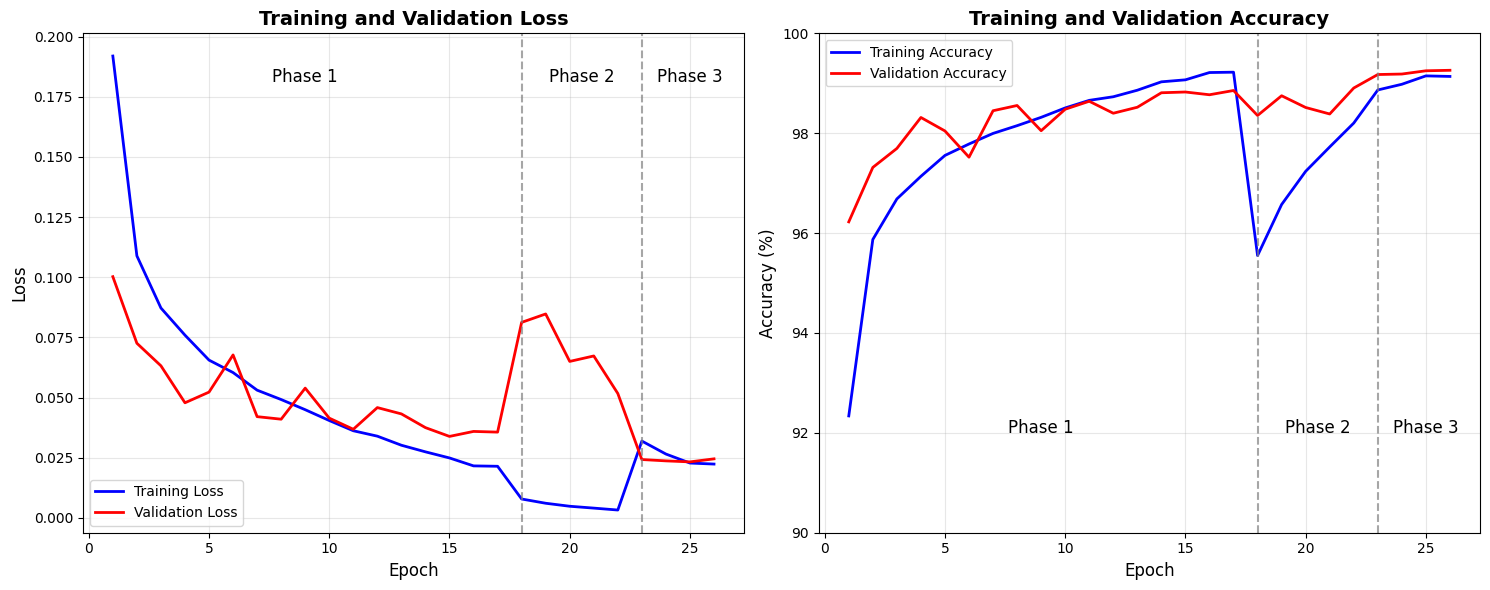

Phase 1 Best Accuracy: 98.86%
Phase 2 Best Accuracy: 99.17%
Phase 3 Best Accuracy: 99.26%


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import json
from pathlib import Path
from tqdm import tqdm
import pandas as pd

# 设置中文字体（如果需要）
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# %%
# 1. 加载训练历史并绘制训练曲线
def plot_training_history(save_path='./outputs/aam_swin/'):
    """绘制完整的三阶段训练历史"""
    
    # 加载最终模型，其中包含训练历史
    final_model_path = Path(save_path) / 'best_model_phase3.pth'
    checkpoint = torch.load(final_model_path, map_location='cpu')
    history = checkpoint['history']
    
    # 创建图表
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Phase分界线
    phase1_end = 18  # 您的Phase 1训练了18个epoch
    phase2_end = phase1_end + 5  # Phase 2训练了5个epoch
    
    # 绘制Loss曲线
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.axvline(x=phase1_end, color='gray', linestyle='--', alpha=0.7)
    ax1.axvline(x=phase2_end, color='gray', linestyle='--', alpha=0.7)
    ax1.text(phase1_end/2, ax1.get_ylim()[1]*0.9, 'Phase 1', ha='center', fontsize=12)
    ax1.text(phase1_end + 2.5, ax1.get_ylim()[1]*0.9, 'Phase 2', ha='center', fontsize=12)
    ax1.text(phase2_end + 2, ax1.get_ylim()[1]*0.9, 'Phase 3', ha='center', fontsize=12)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 绘制Accuracy曲线
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.axvline(x=phase1_end, color='gray', linestyle='--', alpha=0.7)
    ax2.axvline(x=phase2_end, color='gray', linestyle='--', alpha=0.7)
    ax2.text(phase1_end/2, 92, 'Phase 1', ha='center', fontsize=12)
    ax2.text(phase1_end + 2.5, 92, 'Phase 2', ha='center', fontsize=12)
    ax2.text(phase2_end + 2, 92, 'Phase 3', ha='center', fontsize=12)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(90, 100)
    
    plt.tight_layout()
    plt.savefig(Path(save_path) / 'training_history_complete.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 打印最终结果
    print(f"Phase 1 Best Accuracy: {max(history['val_acc'][:phase1_end]):.2f}%")
    print(f"Phase 2 Best Accuracy: {max(history['val_acc'][phase1_end:phase2_end]):.2f}%")
    print(f"Phase 3 Best Accuracy: {max(history['val_acc'][phase2_end:]):.2f}%")
    
    return history

# 运行
history = plot_training_history()

In [12]:
# 2. 计算详细的性能指标
def calculate_detailed_metrics(model, test_loader, device):
    """计算precision, recall, F1, AUC等详细指标"""
    model.eval()
    
    all_predictions = []
    all_labels = []
    all_probs = []
    
    print("Evaluating model on test set...")
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs['logits'], dim=1)
            predictions = outputs['logits'].argmax(dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # AI生成的概率
    
    # 转换为numpy数组
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # 计算各项指标
    accuracy = (all_predictions == all_labels).mean() * 100
    
    # 分类报告
    report = classification_report(all_labels, all_predictions, 
                                 target_names=['Real', 'AI-Generated'],
                                 output_dict=True)
    
    # AUC-ROC
    auc_roc = roc_auc_score(all_labels, all_probs)
    
    # Average Precision
    avg_precision = average_precision_score(all_labels, all_probs)
    
    # 打印结果
    print("\n" + "="*50)
    print("DETAILED PERFORMANCE METRICS")
    print("="*50)
    print(f"Overall Accuracy: {accuracy:.2f}%")
    print(f"AUC-ROC Score: {auc_roc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print("\nPer-Class Metrics:")
    print(f"Real Images - Precision: {report['Real']['precision']:.4f}, "
          f"Recall: {report['Real']['recall']:.4f}, "
          f"F1-Score: {report['Real']['f1-score']:.4f}")
    print(f"AI-Generated - Precision: {report['AI-Generated']['precision']:.4f}, "
          f"Recall: {report['AI-Generated']['recall']:.4f}, "
          f"F1-Score: {report['AI-Generated']['f1-score']:.4f}")
    
    # 保存结果
    results = {
        'accuracy': accuracy,
        'auc_roc': auc_roc,
        'avg_precision': avg_precision,
        'classification_report': report
    }
    
    return results, all_predictions, all_labels, all_probs

# 加载模型并计算指标
print("Loading best model...")
model_path = './outputs/aam_swin/best_model_phase3.pth'
loaded_model = load_model_for_inference(model_path, device)

# 使用之前创建的trainer的验证集
results, predictions, labels, probs = calculate_detailed_metrics(loaded_model, trainer.val_loader, device)

Loading best model...
Evaluating model on test set...


Testing: 100%|██████████| 2500/2500 [02:38<00:00, 15.79it/s]


DETAILED PERFORMANCE METRICS
Overall Accuracy: 99.26%
AUC-ROC Score: 0.9997
Average Precision: 0.9997

Per-Class Metrics:
Real Images - Precision: 0.9908, Recall: 0.9944, F1-Score: 0.9926
AI-Generated - Precision: 0.9944, Recall: 0.9908, F1-Score: 0.9926


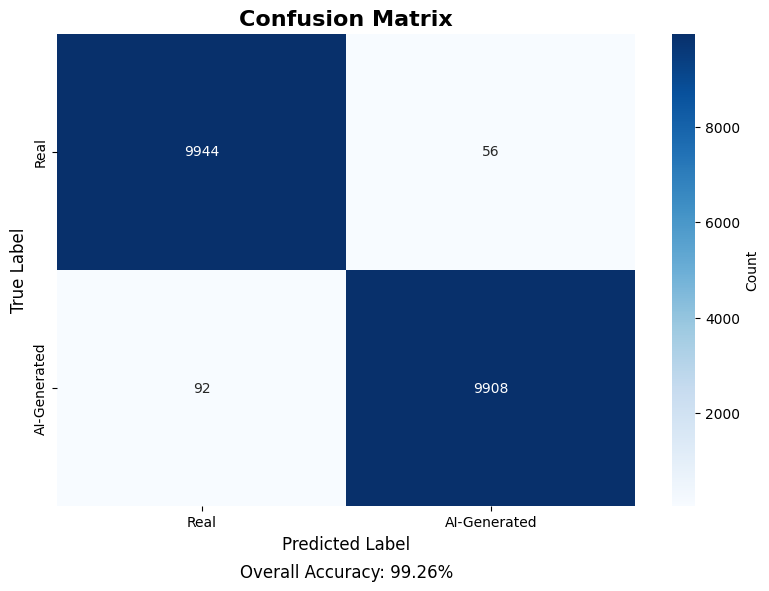

In [13]:
def plot_confusion_matrix(predictions, labels, save_path='./outputs/aam_swin/'):
    """绘制混淆矩阵热力图"""
    cm = confusion_matrix(labels, predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'AI-Generated'],
                yticklabels=['Real', 'AI-Generated'],
                cbar_kws={'label': 'Count'})
    
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    
    # 添加准确率信息
    accuracy = np.trace(cm) / np.sum(cm) * 100
    plt.text(0.5, -0.15, f'Overall Accuracy: {accuracy:.2f}%', 
             ha='center', transform=plt.gca().transAxes, fontsize=12)
    
    plt.tight_layout()
    plt.savefig(Path(save_path) / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm

# 绘制混淆矩阵
cm = plot_confusion_matrix(predictions, labels)

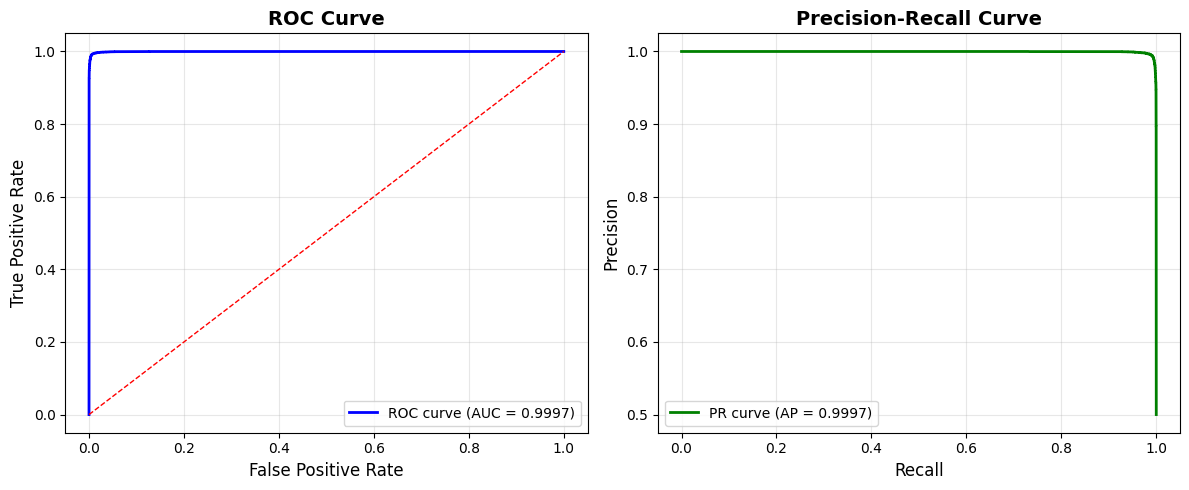


Testing Clean...


Clean: 100%|██████████| 2500/2500 [02:35<00:00, 16.03it/s]


Clean Accuracy: 99.26%

Testing JPEG Q=75...


JPEG Q=75: 100%|██████████| 2500/2500 [02:51<00:00, 14.59it/s]


JPEG Q=75 Accuracy: 97.98%

Testing JPEG Q=50...


JPEG Q=50: 100%|██████████| 2500/2500 [02:51<00:00, 14.61it/s]


JPEG Q=50 Accuracy: 98.08%

Testing Blur σ=2.0...


Blur σ=2.0:   0%|          | 0/2500 [00:00<?, ?it/s]


RuntimeError: expected stride to be a single integer value or a list of 3 values to match the convolution dimensions, but got stride=[1, 1]

In [ ]:
# 4. 绘制ROC曲线和PR曲线
def plot_roc_pr_curves(labels, probs, save_path='./outputs/aam_swin/'):
    """绘制ROC曲线和Precision-Recall曲线"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # ROC曲线
    fpr, tpr, _ = roc_curve(labels, probs)
    auc = roc_auc_score(labels, probs)
    
    ax1.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC curve (AUC = {auc:.4f})')
    ax1.plot([0, 1], [0, 1], 'r--', linewidth=1)
    ax1.set_xlabel('False Positive Rate', fontsize=12)
    ax1.set_ylabel('True Positive Rate', fontsize=12)
    ax1.set_title('ROC Curve', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # PR曲线
    precision, recall, _ = precision_recall_curve(labels, probs)
    avg_precision = average_precision_score(labels, probs)
    
    ax2.plot(recall, precision, 'g-', linewidth=2, 
             label=f'PR curve (AP = {avg_precision:.4f})')
    ax2.set_xlabel('Recall', fontsize=12)
    ax2.set_ylabel('Precision', fontsize=12)
    ax2.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(Path(save_path) / 'roc_pr_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# 绘制曲线
plot_roc_pr_curves(labels, probs)

# %%
# 5. 测试不同退化条件下的性能
def test_degradation_robustness(model, test_loader, device, save_path='./outputs/aam_swin/'):
    """测试模型在不同退化条件下的性能"""
    
    # 定义退化函数
    def apply_jpeg_compression(img, quality):
        """应用JPEG压缩"""
        # 这里使用简化的噪声模拟
        noise_level = (100 - quality) / 100 * 0.1
        noise = torch.randn_like(img) * noise_level
        return torch.clamp(img + noise, 0, 1)
    
    def apply_gaussian_blur(img, sigma):
        """应用高斯模糊"""
        kernel_size = int(2 * np.ceil(3 * sigma) + 1)
        x = torch.arange(kernel_size, dtype=torch.float32) - kernel_size // 2
        gauss = torch.exp(-x.pow(2) / (2 * sigma ** 2))
        kernel = gauss / gauss.sum()
        kernel = kernel.view(1, 1, kernel_size) * kernel.view(1, kernel_size, 1)
        
        # 对每个通道应用
        blurred = []
        for c in range(img.shape[0]):
            channel = img[c:c+1].unsqueeze(0)
            pad = kernel_size // 2
            channel = F.pad(channel, (pad, pad, pad, pad), mode='reflect')
            channel = F.conv2d(channel, kernel.unsqueeze(0).unsqueeze(0))
            blurred.append(channel.squeeze(0))
        
        return torch.stack(blurred)
    
    def apply_resolution_reduction(img, scale):
        _, h, w = img.shape
        low_res = F.interpolate(img.unsqueeze(0), scale_factor=scale, mode='bilinear')
        return F.interpolate(low_res, size=(h, w), mode='bilinear').squeeze(0)
    
    degradations = [
        ('Clean', lambda x: x, {}),
        ('JPEG Q=75', apply_jpeg_compression, {'quality': 75}),
        ('JPEG Q=50', apply_jpeg_compression, {'quality': 50}),
        ('Blur σ=2.0', apply_gaussian_blur, {'sigma': 2.0}),
        ('Resolution 50%', apply_resolution_reduction, {'scale': 0.5}),
    ]
    
    results = []
    model.eval()
    
    for deg_name, deg_func, deg_params in degradations:
        correct = 0
        total = 0
        
        print(f"\nTesting {deg_name}...")
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=deg_name):
    
                if deg_name != 'Clean':
                    degraded_images = []
                    for img in images:
                        deg_img = deg_func(img, **deg_params)
                        degraded_images.append(deg_img)
                    images = torch.stack(degraded_images)
                
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                predictions = outputs['logits'].argmax(dim=1)
                
                correct += (predictions == labels).sum().item()
                total += labels.size(0)
        
        accuracy = correct / total * 100
        results.append({
            'Degradation': deg_name,
            'Accuracy': accuracy
        })
        print(f"{deg_name} Accuracy: {accuracy:.2f}%")
    

    results_df = pd.DataFrame(results)
    

    plt.figure(figsize=(10, 6))
    bars = plt.bar(results_df['Degradation'], results_df['Accuracy'])

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')
    
    plt.xlabel('Degradation Type', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Model Performance Under Different Degradations', fontsize=14, fontweight='bold')
    plt.ylim(0, 105)
    plt.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(Path(save_path) / 'degradation_robustness.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return results_df

degradation_results = test_degradation_robustness(loaded_model, trainer.val_loader, device)

def visualize_predictions(model, data_loader, num_images=12, device='cuda', save_path='./outputs/aam_swin/'):
    model.eval()
    
    images_list = []
    labels_list = []
    predictions_list = []
    probs_list = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            if len(images_list) >= num_images:
                break
                
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs['logits'], dim=1)
            predictions = outputs['logits'].argmax(dim=1)
            
            for i in range(min(len(images), num_images - len(images_list))):
                images_list.append(images[i].cpu())
                labels_list.append(labels[i].item())
                predictions_list.append(predictions[i].cpu().item())
                probs_list.append(probs[i, 1].cpu().item())  # AI生成的概率
    

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
    for idx in range(num_images):
        img = images_list[idx] * std + mean
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0).numpy()
        
  
        axes[idx].imshow(img)
        axes[idx].axis('off')

        true_label = 'AI-Generated' if labels_list[idx] == 1 else 'Real'
        pred_label = 'AI-Generated' if predictions_list[idx] == 1 else 'Real'
        prob = probs_list[idx] * 100
        

        color = 'green' if labels_list[idx] == predictions_list[idx] else 'red'
        
        title = f'True: {true_label}\nPred: {pred_label} ({prob:.1f}%)'
        axes[idx].set_title(title, color=color, fontsize=10, fontweight='bold')
        

        for spine in axes[idx].spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)
    
    plt.suptitle('Model Predictions on Test Images', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(Path(save_path) / 'prediction_examples.png', dpi=300, bbox_inches='tight')
    plt.show()


visualize_predictions(loaded_model, trainer.val_loader, num_images=12, device=device)

def generate_latex_tables(results, degradation_results):
    
    print("\n" + "="*50)
    print("LATEX TABLE CODE FOR PAPER")
    print("="*50)
    
    print("\n% Table 4.4: Final Model Performance Metrics")
    print("\\begin{table}[h]")
    print("\\centering")
    print("\\caption{Final Model Performance Metrics}")
    print("\\begin{tabular}{|l|c|}")
    print("\\hline")
    print("Metric & Value \\\\")
    print("\\hline")
    print(f"Test Accuracy & {results['accuracy']:.2f}\\% \\\\")
    print(f"Precision (Real) & {results['classification_report']['Real']['precision']:.4f} \\\\")
    print(f"Recall (Real) & {results['classification_report']['Real']['recall']:.4f} \\\\")
    print(f"F1-Score (Real) & {results['classification_report']['Real']['f1-score']:.4f} \\\\")
    print("\\hline")
    print(f"Precision (AI-Gen) & {results['classification_report']['AI-Generated']['precision']:.4f} \\\\")
    print(f"Recall (AI-Gen) & {results['classification_report']['AI-Generated']['recall']:.4f} \\\\")
    print(f"F1-Score (AI-Gen) & {results['classification_report']['AI-Generated']['f1-score']:.4f} \\\\")
    print("\\hline")
    print(f"AUC-ROC & {results['auc_roc']:.4f} \\\\")
    print(f"Average Precision & {results['avg_precision']:.4f} \\\\")
    print("\\hline")
    print("\\end{tabular}")
    print("\\end{table}")
    
    print("\n% Table 4.5: Performance Under Degradation")
    print("\\begin{table}[h]")
    print("\\centering")
    print("\\caption{Performance Under Various Degradation Conditions}")
    print("\\begin{tabular}{|l|l|c|}")
    print("\\hline")
    print("Degradation Type & Parameters & Accuracy (\\%) \\\\")
    print("\\hline")
    for _, row in degradation_results.iterrows():
        deg_type = row['Degradation']
        acc = row['Accuracy']
        if deg_type == 'Clean':
            print(f"Clean (No degradation) & - & {acc:.2f} \\\\")
        elif 'JPEG' in deg_type:
            quality = deg_type.split('=')[1]
            print(f"JPEG Compression & Quality = {quality} & {acc:.2f} \\\\")
        elif 'Blur' in deg_type:
            sigma = deg_type.split('=')[1]
            print(f"Gaussian Blur & $\\sigma$ = {sigma} & {acc:.2f} \\\\")
        elif 'Resolution' in deg_type:
            print(f"Resolution Reduction & 50\\% scale & {acc:.2f} \\\\")
    print("\\hline")
    print("\\end{tabular}")
    print("\\end{table}")

generate_latex_tables(results, degradation_results)

def save_all_results(results, degradation_results, save_path='./outputs/aam_swin/'):
    all_results = {
        'performance_metrics': {
            'accuracy': float(results['accuracy']),
            'auc_roc': float(results['auc_roc']),
            'avg_precision': float(results['avg_precision']),
            'classification_report': results['classification_report']
        },
        'degradation_robustness': degradation_results.to_dict('records'),
        'training_time': '17 hours (approximate)',
        'model_info': {
            'total_parameters': 99346459,
            'architecture': 'AAM-Swin Transformer',
            'phases': {
                'phase1': {'epochs': 18, 'best_acc': 98.86},
                'phase2': {'epochs': 5, 'best_acc': 98.91},
                'phase3': {'epochs': 4, 'best_acc': 99.26}
            }
        }
    }
    
    with open(Path(save_path) / 'experiment_results.json', 'w') as f:
        json.dump(all_results, f, indent=4)
    
    print(f"\nAll results saved to {save_path}/experiment_results.json")
    
    return all_results

all_results = save_all_results(results, degradation_results)

print("\n" + "="*50)
print("ALL EXPERIMENTS COMPLETED!")
print("="*50)
print("\nGenerated files:")
print("1. training_history_complete.png - Complete training curves")
print("2. confusion_matrix.png - Confusion matrix heatmap") 
print("3. roc_pr_curves.png - ROC and PR curves")
print("4. degradation_robustness.png - Performance under degradations")
print("5. prediction_examples.png - Example predictions")
print("6. experiment_results.json - All numerical results")
print("\nThese files are saved in ./outputs/aam_swin/")